# Long-Term Prediction 

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Long-term prediction (LTP)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter
import librosa
import librosa.display
import IPython.display as ipd

Compute frequeny response of the long-term predictor
$$
1-P(\mathrm{e}^{\mathrm{j}\Omega}) = \sqrt{(1-b\cdot\cos(N_0\Omega))^2 + b^2\cdot\sin^2(N_0\Omega)}\cdot\mathrm{e}^{-\mathrm{j}\phi_P(\Omega)}
$$
with
$$
\phi_P(\Omega) = -\arctan\left(\frac{b\cdot \sin(N_0\Omega)}{1-b\cos(N_0\Omega)}\right)
$$

In [4]:
def get_LTP_Frequency_Response(Omega, N0, b):    
    phi_P = -np.arctan2(b*np.sin(N0*Omega), 1-b*np.cos(N0*Omega))
    return np.sqrt(np.square((1-b*np.cos(N0*Omega))) + np.square(b*np.sin(N0*Omega))) *np.exp(-1j * phi_P)    

Omega = np.linspace(0,np.pi,10000)


N0 = 100
LTP_Freqb1 = get_LTP_Frequency_Response(Omega, N0, 1)
LTP_Freqb08 = get_LTP_Frequency_Response(Omega, N0, 0.8)


Plot frequency response

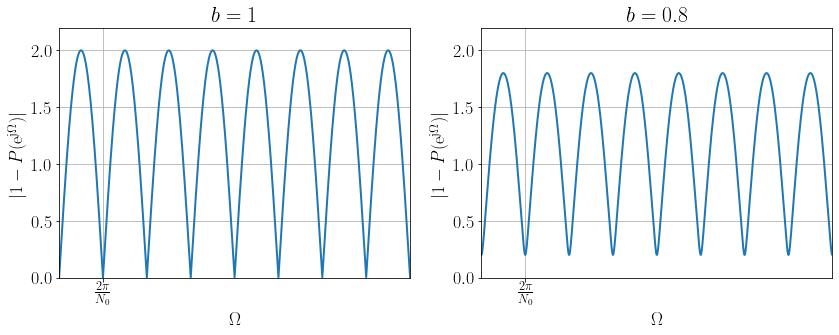

In [5]:
font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(Omega, np.abs(LTP_Freqb1), lw=2)
plt.xlim((0,2*np.pi/N0*8))
plt.ylim((0,2.2))
plt.xticks([2*np.pi/N0], labels=[r'$\frac{2\pi}{N_0}$'])
plt.xlabel('$\Omega$')
plt.ylabel(r'$|1-P(\mathrm{e}^{\mathrm{j}\Omega})|$')
plt.title('$b=1$')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Omega, np.abs(LTP_Freqb08), lw=2)
plt.xlim((0,2*np.pi/N0*8))
plt.ylim((0,2.2))
plt.xticks([2*np.pi/N0], labels=[r'$\frac{2\pi}{N_0}$'])
plt.xlabel('$\Omega$')
plt.ylabel(r'$|1-P(\mathrm{e}^{\mathrm{j}\Omega})|$')
plt.title('$b=0.8$')
plt.grid(True)

plt.tight_layout()
plt.savefig('figure_DST_6.15bc.pdf', bbox_inches='tight')

---
Illustrate long-term prediction on a short speech segment

In [6]:
wave_filename = 'speech_segment.wav'

# load file, do *not* resample
x, sampling_rate = librosa.load(wave_filename, sr=None)

# time in ms
t = np.arange(len(x)) / sampling_rate * 1000.0

In [7]:
# helper function calculating the auto-correlation coefficient r
def get_r(x, l):    
    x_shift = np.roll(x,l)
    x_shift[:l] = 0        
    return np.correlate(x,x_shift)[0]
    
def get_s(x, l):
    x_shift = np.roll(x,l)
    x_shift[:l] = 0        
    return np.correlate(x_shift,x_shift)[0]
    
def get_prediction_coefficients(x, n):
    r = np.array([get_r(x,k) for k in np.arange(1,n+1)])
    R = np.array([np.concatenate(([get_r(x,j) for j in np.arange(i,0,-1)], [get_r(x,j) for j in np.arange(0,n-i)])) for i in range(n)])    
    
    a_opt = np.linalg.inv(R) @ r
    return a_opt

def get_prediction_frequency_response(a, Omega):    
    A = np.ones_like(Omega) + 1j*np.zeros_like(Omega)
    for k in range(len(a)):
        A -= a[k] * np.exp(-1j*(k+1)*Omega)
    return A

In [8]:
# short-term prediction
n = 8
a = get_prediction_coefficients(x, n)
xh = lfilter(np.concatenate(([0], a)), 1, x)

d = x - xh
print(len(x))

660


In [9]:
# find optimal N0 and b
# sweep values
N0_range= np.arange(10,160)
N0_cost = np.zeros_like(N0_range, dtype=float)

for idx,value in enumerate(N0_range):
    N0_cost[idx] = get_s(d, 0) - (get_r(d, value)**2)/get_s(d, value)
    
N0 = N0_range[np.argmin(N0_cost)]

# if we have N0, get b
b = get_r(x, N0)/get_s(x, N0)

In [10]:
# apply long term prediction
dh = lfilter(np.concatenate((np.zeros(N0), [b])), 1, d)

dtilde = d - dh

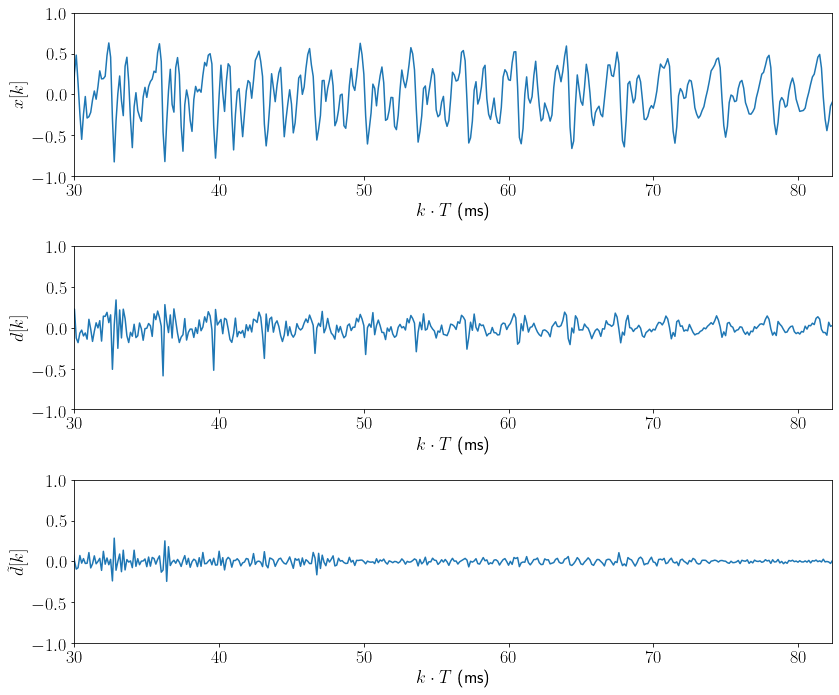

In [11]:
font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
plt.plot(t, x)
plt.xlim((30,t[-1]))
plt.ylim((-1,1))
plt.xlabel('$k\cdot T$ (ms)')
plt.ylabel('$x[k]$')

plt.subplot(3,1,2)
plt.plot(t, d)
plt.xlim((30,t[-1]))
plt.ylim((-1,1))
plt.xlabel('$k\cdot T$ (ms)')
plt.ylabel('$d[k]$')

plt.subplot(3,1,3)
plt.plot(t, dtilde)
plt.xlim((30,t[-1]))
plt.ylim((-1,1))
plt.xlabel('$k\cdot T$ (ms)')
plt.ylabel(r'$\tilde{d}[k]$')

plt.tight_layout()
plt.savefig('figure_DST_6.16b.pdf', bbox_inches='tight')

Plot spectra

In [15]:
X = np.fft.fft(x, 1024)
G = get_prediction_frequency_response(a, Omega)
D = np.fft.fft(d, 1024)
P = 1-get_LTP_Frequency_Response(Omega, N0, b)
Dt= np.fft.fft(dtilde, 1024)

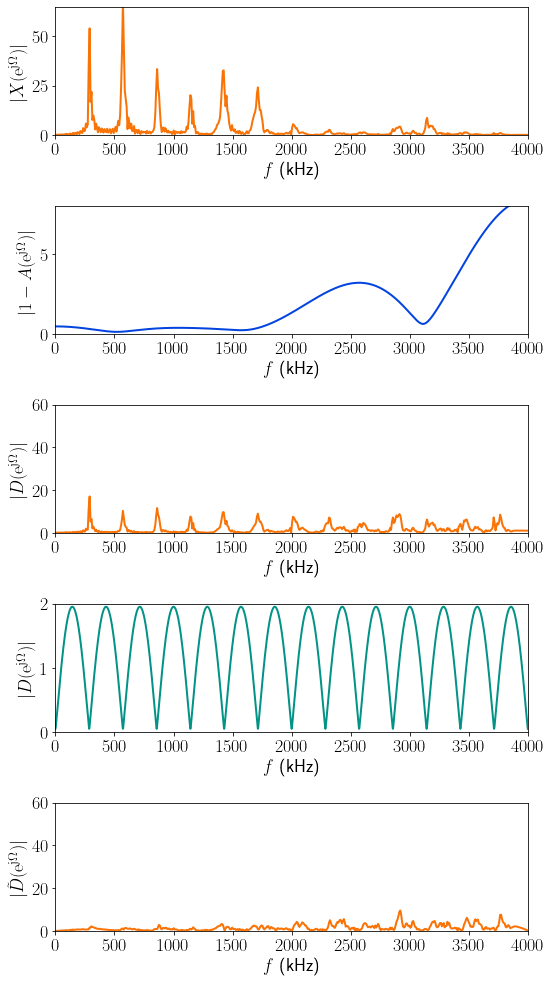

In [16]:
font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.figure(figsize=(8, 14))
plt.subplot(5,1,1)
plt.plot(np.linspace(0,sampling_rate/2,len(X)//2),np.abs(X[:(len(X)//2)]), color='xkcd:orange', lw=2)
plt.xlim((0,sampling_rate/2))
plt.ylim((0,65))
plt.xlabel('$f$ (kHz)')
plt.ylabel('$|X(\mathrm{e}^{\mathrm{j}\Omega})|$')

plt.subplot(5,1,2)
plt.plot(np.linspace(0,sampling_rate/2,len(Omega)),np.abs(G), color='xkcd:blue', lw=2)
plt.xlim((0,sampling_rate/2))
plt.ylim((0,8))
plt.xlabel('$f$ (kHz)')
plt.ylabel('$|1-A(\mathrm{e}^{\mathrm{j}\Omega})|$')

plt.subplot(5,1,3)
plt.plot(np.linspace(0,sampling_rate/2,len(D)//2),np.abs(D[:(len(X)//2)]), color='xkcd:orange', lw=2)
plt.xlim((0,sampling_rate/2))
plt.ylim((0,60))
plt.xlabel('$f$ (kHz)')
plt.ylabel('$|D(\mathrm{e}^{\mathrm{j}\Omega})|$')

plt.subplot(5,1,4)
plt.plot(np.linspace(0,sampling_rate/2,len(Omega)),np.abs(1-P), color='xkcd:teal', lw=2)
plt.xlim((0,sampling_rate/2))
plt.ylim((0,2))
plt.xlabel('$f$ (kHz)')
plt.ylabel('$|D(\mathrm{e}^{\mathrm{j}\Omega})|$')

plt.subplot(5,1,5)
plt.plot(np.linspace(0,sampling_rate/2,len(Dt)//2),np.abs(Dt[:(len(X)//2)]), color='xkcd:orange', lw=2)
plt.xlim((0,sampling_rate/2))
plt.ylim((0,60))
plt.xlabel('$f$ (kHz)')
plt.ylabel(r'$|\tilde{D}(\mathrm{e}^{\mathrm{j}\Omega})|$')

plt.tight_layout()
plt.savefig('figure_DST_6.17_part.pdf', bbox_inches='tight')